# An Introduction to Logistic Regression

Logistic regression allows us to make predictions over binary outcomes. For example, you might want to determine whether a material will fail under an applied stress or classify a material as being an insulator or a conductor. We do this by applying a transform to the familiar linear regression formula such that we now model the relationship between our independent variables and the log-odds of our dependent variable.

$$p(X) = \beta_0 + \beta_1 X$$
$$ \log \left( \frac{p(X)}{1 - p(X)} \right) = \beta_0 + \beta_1 X$$
$$ p(X) = \frac{e^{\beta_0 + \beta_1 X}}{1-e^{\beta_0 + \beta_1 X}}$$

This is known as the logistic function. It takes on an S-shape, which conincides with how we might wish to model the change between two binary outcomes.

In this notebook, we will use logistic regression to model and predict failure in both the challenger disaster and a relevant materials classification problem. Please note that many engineering challenges and failures cannot be boiled down to a simple variable and that there are many competing variables at play in such incidents that cannot be easily modeled.

In [119]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# some settings for making plots
import matplotlib.pyplot as plt
from cycler import cycler
plt.style.use("ggplot")
palette = ["#00B0F6", "#F8766D", "#00BF7D", "#A3A500", "#E76BF3"]
plt.rc('axes', prop_cycle=(cycler('color', palette)))

We begin by reading in the data, cleaning it, and splitting it into training and testing data. In this hypothetical situation, we are placing ourselve in the position of trying to determine if an incident will occur on launch day based on the previous incident data.

In [120]:
df = pd.read_csv("challenger_data.csv")
df.columns = ['date', 'temperature', 'damage_incident'] # simplify column names
df.dropna(inplace=True) # drop the NAN value

df.iloc[-1, -1] = 1 # replace the challenger incident label with a 1
df['damage_incident'] = df['damage_incident'].astype(int) # convert indicent to int type

df_train = df.iloc[:-1, :].copy() # create a dataset for training the model
df_test = pd.DataFrame([df.iloc[-1, :].copy()]) # create a dataset for testing the model

# take a look at what our data looks like from a statistical perspective
print("df_train stats")
df_train.describe()

df_train stats


,temperature,damage_incident
count,23.000000,23.000000
mean,69.565217,0.304348
std,7.057080,0.470472
min,53.000000,0.000000
25%,67.000000,0.000000
50%,70.000000,0.000000
75%,75.000000,1.000000
max,81.000000,1.000000


While numerical statistics are useful, it can be helpful to visualize the data graphically to build some intution for relationships between variables and features that might pose problems. In this example, we only have a single variable, but as we shall see in later examples, things aren't always simple.

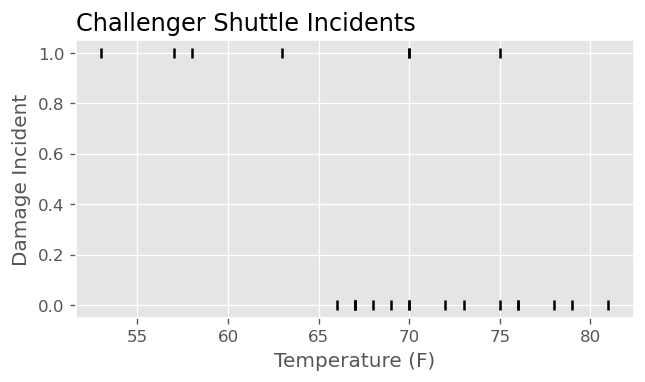

In [121]:
fig, ax = plt.subplots(figsize=(6,3), dpi=120)
plt.scatter(
    df_train['temperature'], 
    df_train['damage_incident'],
    color='k',
    marker='|')
plt.title("Challenger Shuttle Incidents", loc='left')
plt.xlabel("Temperature (F)")
plt.ylabel("Damage Incident")
plt.show()

We can fit a logistic regression model with `statsmodels` by calling `smf.logit` and then filling in the familiar formula syntax. As the relationship is quite simple, we won't consider higher order models for predicting this dataset.

In [122]:
model = smf.logit('damage_incident ~ temperature', data=df_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.441635
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        damage_incident   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Jan 2024   Pseudo R-squ.:                  0.2813
Time:                        14:40:54   Log-Likelihood:                -10.158
converged:                       True   LL-Null:                       -14.134
Covariance Type:            nonrobust   LLR p-value:                  0.004804
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      15.0429      7.379      2.039      0.041       0.581      29.505
temperature    -0.2322    

Recall that our transform of the linear relationship is now causing us to model the log odds of the response. Recall as well the interpretation of odds from a statistical stand point:

$$ \log (\text{odds}) \quad \text{where odds} = \frac{\text{Probability of Event}}{\text{Probability of Non-Event}}$$

Because we have transformed our model, we need to change our intepretation of our model coefficients. We are modeling the linear relationship between our independent variables and the log-odds of failure. The `Intercept` now provides the log odds of an incident when `temperature=0`, which would suggest that at low temperatures the probability of an incident occuring is highly likely. Looking at the `temperature` coefficient, we see that for a unit increase in temperature the log odds of an incident **decrease** by 0.2322. We can convert this to odds ratio change by exponentiating to get 0.793. This can be understood as a unit temperature change affecting 79.3% decrease in the odds ratio of failure; that is, a 79.3% decrease from the previous odds.

### Plotting our Predictions
We can examine our model graphically by using to to predict on temperatures that span the temperature range of interest. In the code below we create some dummy data and use our trained model to predict the probability of an incident with it. In addition to the mean response, we alos include the confidence intervals on our predictions. The inclusion of confidence intervals can give us a measure of uncertinaty in the *true* relationship between our dependent and independent variables.

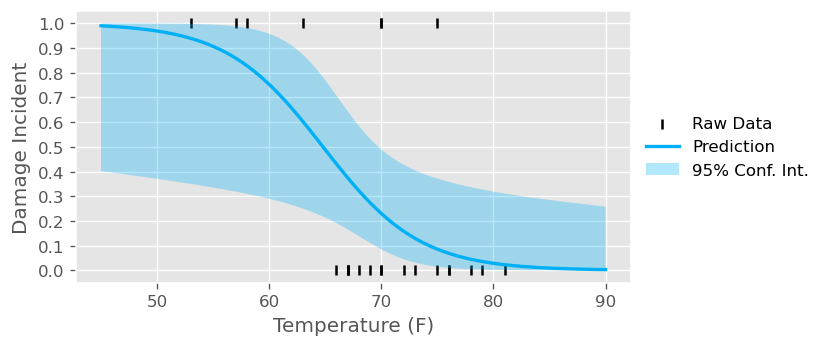

In [123]:
# create some dummy data to predict over
temp_data = pd.DataFrame({'temperature':np.linspace(45, 90, 100)})
sm.add_constant(temp_data)
predictions = model.get_prediction(temp_data)

preds = predictions.predicted # get predicted values
conf_ints= predictions.conf_int() # get confidence intervals

fig, ax = plt.subplots(figsize=(7,3), dpi=120, layout='tight')
plt.scatter(
    df_train['temperature'], 
    df_train['damage_incident'],
    color='k',
    marker='|',
    label='Raw Data')

plt.plot(temp_data, preds, lw=2, label="Prediction")
plt.fill_between(temp_data.iloc[:,0], conf_ints[:,0], conf_ints[:,1], alpha=0.3, label="95% Conf. Int.")
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xlabel("Temperature (F)")
plt.ylabel("Damage Incident")
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We are now able to predict the probability of an incident occuring as a function of temperature, but our task isn't finished. Our aim is to be able to provide a definite answer as a function of temperature, which means we need to convert these probabilities into a binary decision.

### Selecting a Threshold

Now that we have our model, we need to define a probability threshold from which we will render a decision. A naive first attempt might be to say that anything above 50% failure probability is a 1 and anything below 50% failure probability is a 0. To assess the impacts of this classification threhsold we can test the accuracy of these predictions and construct a confusion matrix. The confusion matrix gives a better understanding of which classes we are misclassifying.

In [124]:
train_pred = model.predict(df_train) # predict the training data

threshold=0.5 # set a decision threshold

train_pred = np.where(train_pred>threshold, 1, 0) # apply the threshold

print("Prediction Accuracy: ", accuracy_score(df_train['damage_incident'], train_pred))

cm = confusion_matrix(df_train['damage_incident'], train_pred)
print("True Positive ", cm[1,1])
print("False Negative", cm[1,0], "(!)")
print("False Positive", cm[0,1])
print("True Negative ", cm[0,0])

Prediction Accuracy:  0.8695652173913043
True Positive  4
False Negative 3 (!)
False Positive 0
True Negative  16


Our prediction accuracy doesn't seem too bad, but the confusion matrix tells us that our model predicts an incident-free flight incorrectly for three of the datapoints! Under some circumstances, this level of error might be ok, but when human lives are on the line, we may wish to be a bit more conservative with our selection threshold.

Deciding an optimal threshold falls into a branch of mathematics called decision theory, for which there is an extensive literature. Depending on the complexity of the response you are attempting to predict, you might have an equally complex decision function that takes into account the uncertainty in that prediction in additional to other potential variables that are computed seperately. Under some circumstances it may be acceptable to have the model say I don't know if there isn't a clear answer and have the problem further analyzed by humans. One should think critically about the impacts of a particular decision to guide the selection of an appropriate threshold. In the case of a multi-billion dollar rocket carrying human souls, a lower threshold that better guarantees survival might be more appropriate.

### Predicting Failure on Launch Day

Now we can test our model on launch day conditions and make a decision as to whether it is safe to proceed with the launch.

In [125]:
launch_pred = model.get_prediction(df_test)

print("Predicted Failure Probability", launch_pred.predicted[0])
print("Predicted Failure Probability Bounds", launch_pred.conf_int()[0])
print(f"Incident Decision: {1 if launch_pred.predicted[0] > 0.2 else 0}")

Predicted Failure Probability 0.9996087828849319
Predicted Failure Probability Bounds [0.48160892 0.99999986]
Incident Decision: 1


## A New Problem with More Variables

A company comes to you asking to use a material you made in a machine they are designing. They provide you with some expected environmental conditions and ask you if you material will be able to survive. Thankfully you have data on your material under similar conditions and now know how to build a model to predict failure under new conditions.

The company says that their material will be under the following conditions:
- temperature: 250,
- applied_tensile_stress: 120
- humidity: 0.3
- corrosive_index: 0.8

Using the component_failure dataset, we will build a model to predict whether our material will fail under these conditions.

In [126]:
df = pd.read_csv('component_failure.csv')
df.describe()

,temperature,applied_tensile_stress,humidity,corrosive_index,fail
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,159.594441,247.253112,0.298021,0.536893,0.135000
std,48.368328,24.931416,0.105313,0.351709,0.342581
min,69.569229,184.809075,0.070802,0.000039,0.000000
25%,122.701791,231.455975,0.196427,0.236979,0.000000
50%,153.656855,246.802360,0.316220,0.504828,0.000000
75%,190.082300,263.407783,0.394585,0.900277,0.000000
max,333.189426,324.336097,0.484368,0.999998,1.000000


We plot the data below to gain some intuition for which predictors might be good in a model and try to understand the data a little better.

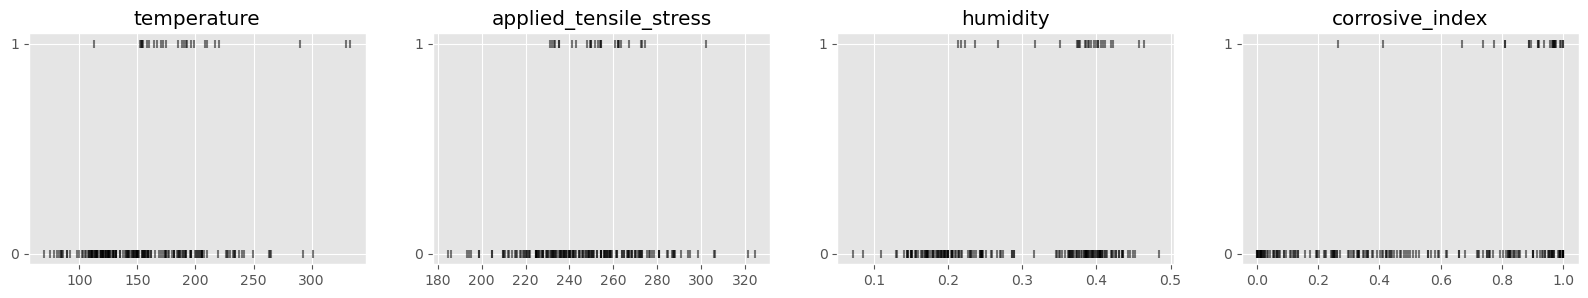

In [127]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 3))

for i in range(4):
    ax[i].set_title(df.columns[i])
    ax[i].scatter(df.iloc[:,i], df.fail, color='k', marker='|', alpha=0.5)
    ax[i].set_yticks([0,1])

As a first pass, we think that `corrosive_index` might be a good predictor, so we attempt to build a simple model with that predictor and look at the results.

In [128]:
pred_var = 'corrosive_index'
model = smf.logit(f'fail ~ {pred_var}', data=df).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.309254
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   fail   No. Observations:                  200
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Jan 2024   Pseudo R-squ.:                  0.2186
Time:                        14:40:55   Log-Likelihood:                -61.851
converged:                       True   LL-Null:                       -79.156
Covariance Type:            nonrobust   LLR p-value:                 4.025e-09
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -5.3598      1.003     -5.345      0.000      -7.325      -3.394
corrosive_inde

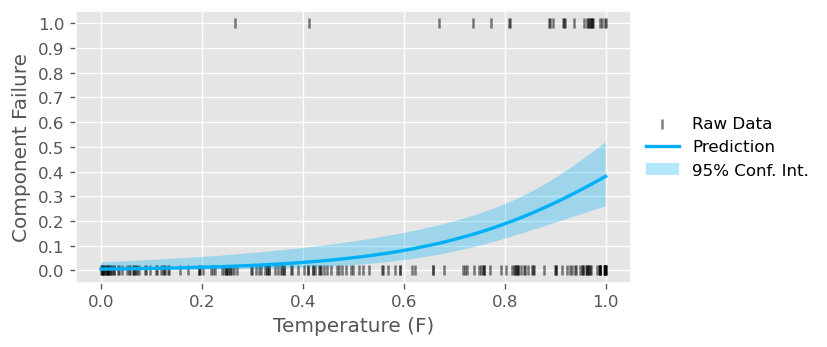

In [129]:
pred_data = df[pred_var].sort_values()
sm.add_constant(pred_data)
predictions = model.get_prediction(pred_data)

preds = predictions.predicted
conf_int = predictions.conf_int()

fig, ax = plt.subplots(figsize=(7,3), dpi=120, layout='tight')
plt.scatter(
    df[pred_var], 
    df['fail'],
    color='k',
    marker='|',
    label='Raw Data',
    alpha=0.5)

plt.plot(pred_data, preds, lw=2, label="Prediction")

plt.fill_between(pred_data, conf_int[:,0],conf_int[:,1], alpha=0.3, label="95% Conf. Int.")

plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.xlabel("Temperature (F)")
plt.ylabel("Component Failure")
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The single predictor model isn't a great fit, and is show to have weak predictive performance. Looking at the data again, none of the materials immediately stick out as good predictors, but we shouldn't always expect there to be easy relationships! We can try to gain some addition insights by plotting the data in higher dimensions and seeing if we can gain some additional understanding. 

Below we plot the data in 2D with color coded failure information to see if we can discern a better combination of predictors.

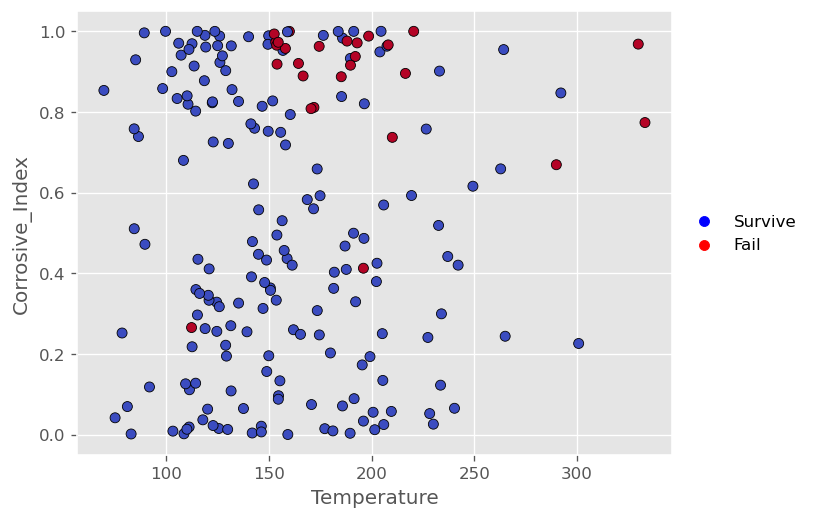

In [130]:
fig, ax = plt.subplots(dpi=120)
plt.scatter(df.temperature, df.corrosive_index, c=df.fail, cmap='coolwarm', edgecolors='k')
plt.scatter([],[], color='blue', label='Survive')
plt.scatter([],[], color='red', label='Fail')
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Temperature")
plt.ylabel("Corrosive_Index")
plt.show()

The plot above seems to suggest that failure is positively correlated with `temperature` and `corrosive_index`, so perhaps an interaction between the two variables would provide a better predictive model. As a materials scientist, I know that reaction rate is related to temperature, so I think a new variables represented by `temperature * corrosive_index` might give me better performance.

In [131]:
model = smf.logit('fail ~ temperature:corrosive_index', data=df).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.266330
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   fail   No. Observations:                  200
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Jan 2024   Pseudo R-squ.:                  0.3271
Time:                        14:40:55   Log-Likelihood:                -53.266
converged:                       True   LL-Null:                       -79.156
Covariance Type:            nonrobust   LLR p-value:                 6.205e-13
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -5.1748      0.762     -6.791      0.000   

Including that an a few other variables has increased our `Pseudo R-squ.` value, indicating a much better fit! For a limited number of predictors we can graphically visualize the model's decision boundary on a 2D plot. We do this below and overlay the training data on it to see how well the model is performing.

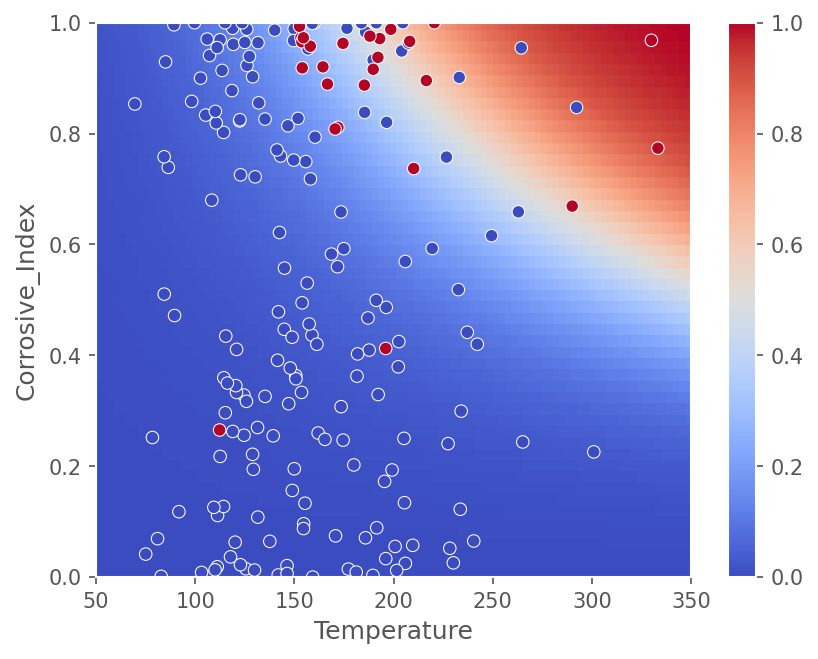

In [132]:
temperature_range = np.linspace(50, 350, num=100)
corrosive_index_range = np.linspace(0, 1, num=50)

# Create a grid of points using numpy.meshgrid
temperature_grid, corrosive_index_grid = np.meshgrid(temperature_range, corrosive_index_range)

# Flatten the grids to create 1D arrays
temperature_values = temperature_grid.flatten()
corrosive_index_values = corrosive_index_grid.flatten()

# Create a DataFrame with the temperature and corrosive index values
df_grid = pd.DataFrame({'temperature': temperature_values, 'corrosive_index': corrosive_index_values})

pred = model.predict(df_grid)

fig, ax = plt.subplots(dpi=150)
plt.scatter(df_grid.temperature, df_grid.corrosive_index, c=pred, cmap='coolwarm', marker='s')
plt.scatter(df.temperature, df.corrosive_index, c=df.fail, cmap='coolwarm', edgecolors='w')
plt.ylim(0,1)
plt.xlim(50,350)
plt.xlabel("Temperature")
plt.ylabel("Corrosive_Index")
plt.colorbar()
plt.show()

Even with the interaction term it looks like we need a more powerful model. We can add additional variables to the model to add some predictive power. We will now add the rest of the variables to the model and see another increase in model accuracy. While we could probably improve the model further, we will call it good enough and try to predict on the companies data.

In [133]:
model = smf.logit('fail ~ temperature:corrosive_index + humidity + applied_tensile_stress', data=df).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.228961
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   fail   No. Observations:                  200
Model:                          Logit   Df Residuals:                      196
Method:                           MLE   Df Model:                            3
Date:                Wed, 24 Jan 2024   Pseudo R-squ.:                  0.4215
Time:                        14:40:55   Log-Likelihood:                -45.792
converged:                       True   LL-Null:                       -79.156
Covariance Type:            nonrobust   LLR p-value:                 2.141e-14
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     -14.7799      3.600     -4.106      0.000   

Our model's accuracy on the training data isn't too bad at the default threshold, despite our weak pseudo r-squ. value we might be ok!

In [134]:
pred_df = df.iloc[:,:-1]
pred = model.predict(pred_df)

threshold=0.5

pred = np.where(pred>threshold, 1, 0)

print("Prediction Accuracy: ", accuracy_score(df['fail'], pred))

cm = confusion_matrix(df['fail'], pred)
print("True Positive ", cm[1,1])
print("False Negative", cm[1,0], "(!)")
print("False Positive", cm[0,1])
print("True Negative ", cm[0,0])

Prediction Accuracy:  0.905
True Positive  12
False Negative 15 (!)
False Positive 4
True Negative  169


Load the data and make a prediction using the model.

In [135]:
client_data = pd.DataFrame({
    "temperature": 250,
    'applied_tensile_stress': 120,
    'humidity': 0.3,
    'corrosive_index': 0.8
}, index=[0])

client_pred = model.get_prediction(client_data)

print("Predicted Failure Probability", client_pred.predicted[0])
print("Predicted Failure Probability Bounds", client_pred.conf_int()[0])
print(f"Failure Decision: {1 if client_pred.predicted[0] > 0.5 else 0}")

Predicted Failure Probability 0.049469763831382366
Predicted Failure Probability Bounds [0.00287478 0.48440074]
Failure Decision: 0
